## <span style="color:white">Data Science Immersive Capstone Project</span>
### <span style="color:#CCC">Chris Huber, chrishubersf@gmail.com</span>
#### <span style="color:#AAA">A predictive study of edible wild mushroom growth in the greater San Francisco Bay Area</span>

### <span style="color:white">Problem Statement</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>Given prior data records of findings of edible wild edible mushroom species with latitude/longitude coordinates, species names, dates of sightings, weather conditions, <strikethrough>substrate composition</strikethrough>, and other relevant factors can I predict for a given period the likelihood of finding certain species of mushrooms that grow natively in the Bay Area.</p>
</div>

#### Add modeling hows/steps/flowchart? (going forward)
#### Visualizations

### <span style="color:white">Proposed Methods and Models</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>I propose to use MySQL as a database backend and Python/Pandas as the main technologies to analyze and deliver my findings</p>
<p>Sourcing the data is tricky: the records I have been able to find are often partial, imperfect, and even potentially inaccurate. However, the source is a reputable and well-known one among mycologists and as such I should be able to detect improperly formatted or submitted data with some thorough EDA.</p>
<p>An abundance of weather data has been and continues to be published daily by the U.S. Meterological Service and as such I should be able to import the relevant data from their website.</p>
<p>Mushrooms blooms in the Bay Area tend to occur during wet winter seasons. However, if the winter is dry they can be delayed until the spring. I intend to look at the correlation between the reported find dates and seasonal variations in temperature, precipitation, and humidity.
</div>

### <span style="color:white">Risks and Assumptions of Data</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>One of the major risks of this dataset is that it does not record quantity, simply occurrences. This means that while the mushrooms of the same species typically grow in a given area, there is no guarantee of the amount. Thus, this should not be seen as a guide to finding any particular amount of a given mushroom but rather its existence in an area.</p>
<p>Another risk is that the mushroom-related data is user-entered and as such could be erroneous or even outright false. However, there would be no perceivable benefit to falsifying this type of data so I do not forsee this being a major issue. I will need to monitor for gross anomolies in the data in cae this type of phenomenon exists.</p>
</div>

### <span style="color:white">Data Sources</span>
<div style="margin-left: 30px; margin-right: 30px;">
<p>
My main data source is a MySQL database dump that the curator for Mushroom Observer, a user-submitted mushroom documenting website, released to me. I also have data listing the species of mushrooms showcased at the San Francisco Fungus Fair (SFFF) and the general location where they were found. If possible, I intend to combine as much data as I can from different sources to create an even more robust dataset.
</p>
</div>

### <span style="color:white">Importing all Required Python Libraries</span>

In [688]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import MySQLdb
import math
import mplleaflet

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.cross_validation import train_test_split, KFold, cross_val_score, cross_val_predict
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler, RobustScaler
# from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, BaggingClassifier, RandomForestClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder

ss = StandardScaler()
skb = SelectKBest(f_classif, k=6)

from IPython.display import display, HTML
display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

plt.rcParams['xtick.color'] = 'white'
plt.rcParams['ytick.color'] = 'white'
%matplotlib inline
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 999)

### <span style="color:white">Creating a MySQL Connection</span>

In [689]:
mysql_cn= MySQLdb.connect(host='localhost', 
                port=3306,user='capstone', passwd='mushr0Om', 
                db='mushroom_observer')
mush_obsv_df = pd.read_sql('SELECT * from bay_area_observations;', con=mysql_cn)
mush_obsv_df = mush_obsv_df.set_index(['id'])
mush_names_df = pd.read_sql('SELECT * from bay_area_names;', con=mysql_cn)
mush_names_df = mush_names_df.set_index(['id'])
mush_locs_df = pd.read_sql('SELECT * from bay_area_locations;', con=mysql_cn)
mush_locs_df = mush_locs_df.set_index(['id'])
# print('Loaded dataframe from MySQL. Records:', len(mush_df))

# mush_obsv.head()
mush_locs_df.head(1)

version          created_at          updated_at  user_id  description_id  \
id                                                                             
21  3       2008-01-04 22:48:03 2010-08-14 01:56:45  1       NaN               

    rss_log_id  num_views           last_view    north   south     west  \
id                                                                        
21 NaN          219       2018-09-05 19:40:30  38.1464  38.039 -122.624   

       east  high  low  ok_for_export  \
id                                      
21 -122.486 NaN   NaN   1               

                                                                                                                                     notes  \
id                                                                                                                                           
21  [admin - Sat Aug 14 01:56:45 +0000 2010]: Changed location name from 'Novato, Marin Co., California, USA' to 'Novato, California, USA'   

                       name          scientific_name  locked  
id                                                            
21  Novato, California, USA  USA, California, Novato  0

### Edible Mushroom List
<pre>
Agaricus augustus - The Prince (not choice)
Agaricus subrutilescens - Wine-colored Agaricus (choice)
Amanita augusta - Blushing Yellow Veil Amanita (not choice)
Amanita caesarea - Caesar's Mushroom
Amanita calyptroderma - Coccora, Coccoli
Amanita novinupta - Blusher (choice)
Amanita sect. Vaginatae (Amanita vaginata) - Grisette (not choice)
Amanita velosa - Springtime Amanita
Armillaria mellea
Auricularia auricula-judae - Jew's ear, wood ear, or jelly ear mushroom
Boletus badius - Bay Bolete
Boletus edulis - Porcini mushroom
Boletus edulis var. grandedulis
Boletus regineus - Queen Bolete (choice)
Calvatia gigantea - Giant Puffball
Cantharellus californicus - oak chanterelle (choice)
Cantharellus cibarius - yellow chanterelle (choice)
Cantharellus tubaeformis - tube or yellow-leg chanterelle
Chlorophyllum brunneum - Shaggy parasol (choice, but not recommended)
Clavaria fragilis - Fairy Fingers (not choice)
Clitocybe nuda (Lepista nuda) - Wood Blewit (choice)
Coprinellus micaceus - Mica Cap, Shiny Cap, and Glistening Inky Cap (choice)
Coprinus comatus - Shaggy Ink Cap/Mane, Lawyer's Wig (choice)
Entoloma medianox - Midnight Entoloma (choice)
Flammulina velutipes - Enoki mushroom (choice)
Gliophorus psittacinus - Parrot Toadstool, Parrot Waxcap *
Gomphidius oregonensis - Insidious Gomphidius (not choice) 
Grifola frondosa - Hen of the Woods
Gymnopus dryophilus (not choice)
Hericium erinaceus - lion's mane mushroom (choice)
Himematsutake - "princess matsutake"
Hydnum repandum - Hedgehog mushroom/Urchin of the Woods
Hypsizygus tessellatus/Hypsizygus marmoreus - beech mushroom, white/brown varieties
Laccaria amethysteo-occidentalis
Lacrymaria lacrymabunda (not choice) *
Lactarius deliciosus - Saffron Milk Cap
Lactarius rubidus - Candy Cap, Curry Milk Cap
Lactarius rufulus - Rufous Candy Cap
Laetiporus gilbertsonii *
Leccinum manzanitae - Manzanita Bolete (choice)
Lentinula edodes - shiitake (choice)
Morchella - Morel family
Morchella conica var. deliciosa - Morel
Morchella esculenta var. rotunda - Morel
Panaeolus papilionaceus - Petticoat mottlegill (not choice)
Pleurotus, Pleurotus ostreatus - oyster mushrooms
Pluteus cervinus - Deer Shield, Deer/Fawn mushroom (not choice)
Schizophyllum commune (not choice) *
Suillus fuscotomentosus
Suillus pungens - pungent slippery jack (not choice)
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
Tricholoma matsutake - matsutake
Tuber aestivum - Black summer truffle
Tuber birch
Tuber brumale
Tuber indicum - Chinese black truffle
Tuber macrosporum - Smooth black truffle
Tuber mesentericum - The Bagnoli truffle
Volvariella volvacea - paddy straw mushroom or straw mushroom
Volvopluteus gloiocephalus - Big Sheath mushroom, Rose-Gilled Grisette, or Stubble Rosegill (not choice)
</pre>

* for some

### Medicinal Mushroom List
<pre>
Panaeolus foenisecii - Mower's Mushroom, Brown Hay Mushroom
Trametes betulina - Gilled Polypore, Birch Mazegill, Multicolor Gill 
Trametes versicolor - Turkey Tail
Tremella fuciformis - snow fungus, snow ear, silver ear fungus, and white jelly mushroom
</pre>

### Psychoactive Mushroom List
<pre>
Gymnopilus luteofolius - Yellow-Gilled Gymnopilus
Inocybe corydalina
Omphalotus olivascens
Panaeolus cinctulus (Panaeolus papilionaceus group) - Banded Mottlegill, Weed Panaeolus or Subbs
Psilocybe allenii
Psilocybe cyanescens - Wavy cap
</pre>

### Poisonous Mushroom List
<pre>
Agaricus californicus *
Agaricus hondensis - Felt-Ringed Agaricus
Agaricus xanthodermus *
Amanita amerimuscaria
Amanita gemmata - Gemmed Amanita
Amanita muscaria subsp. flavivolvata
Amanita phalloides
Amanita ocreata
Boletus eastwoodiae - Satan's Bolete *
Chlorophyllum molybdites - Vomiter Mushroom
Galerina marginata - Funeral Bell, Deadly Skullcap
Hebeloma crustuliniforme - Poison Pie, Fairy Cakes
Hypholoma fasciculare - Sulfur Tuft
Inocybe geophylla% - Common White Inocybe, Earthy Inocybe, White Fibercap
Leratiomyces ceres - Redlead Roundhead
Psathyrella
Omphalotus olivascens
Suillellus amygdalinus *

* for some
</pre>

### Other Scientific Interest List
<pre>
Amanita magniverrucata - Great Pine Jewel
Annulohypoxylon thouarsianum
Aureoboletus flaviporus
Bolbitius titubans
Caulorhiza umbonata
Clathrus ruber - Latticed Stinkhorn, Basket Stinkhorn, Red Cage
Coprinellus sect. Micacei
Coprinopsis lagopus - Harefoot mushroom
Cortinarius glutinosoarmillatus - Slimy Belt
Cortinarius subgenus Telamonia
Entoloma subgenus Leptonia
Entoloma subgenus Nolanea
Ganoderma brownii
Gymnopilus luteofolius
Gymnopilus ventricosus
Helvella dryophila
Hericium coralloides - Coral tooth
Hygrocybe acutoconica
Hygrocybe flavescens
Hygrocybe singeri
Hygrophorus eburneus - Ivory Waxy Cap or the Cowboy's Handkerchief *
Phaeolus schweinitzii - Velvet-top Fungus, Dyer's Polypore
Lactarius alnicola - Golden milk cap
Lactarius argillaceifolius var. megacarpus
Leratiomyces percevalii
Leucopaxillus albissimus
Marasmiellus candidus
Marasmius plicatulus
Mycena acicula - Orange Bonnet, Coral Spring
Mycena galericulata - Common Bonnet, Toque Mycena, Rosy-Gill Fairy Helmet
Mycena haematopus - Bleeding Fairy Helmet, Burgundydrop Bonnet
Mycena purpureofusca - Purple-Edge Bonnet
Panus conchatus - Lilac Oysterling
Psathyrella candolleana
Psathyrella longipes
Psathyrella piluliformis
Russula cremoricolor
Russula sanguinaria (Russula sanguinea) - Bloody Brittlegill
Stereum hirsutum - False turkey tail
Stropharia ambigua
Suillus caerulescens
Tremella aurantia - Golden ear
Tricholoma dryophilum
Tubaria furfuracea - Scurfy twiglet
Xylaria hypoxylon ("Xylaria hypoxylon group") - candlestick fungus, carbon antlers, stag's horn fungus
</pre>

In [690]:
### MAKE HISTOGRAM OF EDIBLE MUSHROOM DISTRIBUTIONS!!

In [691]:
# edible_mushroom_list = ['Amanita velosa', 'Pleurotus ostreatus', 'Boletus edulis', 'Boletus badius', 'Cantharellus californicus', 
#                         'Cantharellus cibarius', 'Cantharellus tubaeformis', 'Chlorophyllum brunneum'
#                         'Calvatia gigantea', 'Lentinula edodes', 'Auricularia auricula-judae', 'Volvariella volvacea',
#                         'Flammulina velutipes', 'Hericium erinaceus', 'Tremella fuciformis', 'Hypsizygus tessellatus',
#                         'Hypsizygus marmoreus', 'Grifola frondosa', 'Hydnum repandum', 'Lactarius deliciosus', 'Tricholoma matsutake',
#                         'Himematsutake', 'Morchella conica', 'Morchella esculenta', 'Tuber aestivum', 'Tuber birch', 'Tuber brumale',
#                         'Tuber indicum', 'Tuber macrosporum', 'Tuber mesentericum', 'Amanita caesarea', 'Armillaria mellea'
#                        ]

choice_mushroom_list = ['Agaricus subrutilescens','Amanita novinupta','Boletus edulis','Boletus edulis var. grandedulis','Boletus regineus','Cantharellus californicus','Cantharellus cibarius','Cantharellus tubaeformis','Chlorophyllum brunneum','Clitocybe nuda','Lepista nuda','Coprinellus micaceus','Coprinus comatus','Entoloma medianox','Flammulina velutipes','Grifola frondosa','Hericium erinaceus','Himematsutake','Lactarius deliciosus','Lactarius rubidus','Lactarius rufulus','Leccinum manzanitae','Lentinula edodes','Morchella conica var. deliciosa','Morchella esculenta var. rotunda','Tremella fuciformis','Tricholoma matsutake','Tuber aestivum','Tuber birch','Tuber brumale','Tuber indicum','Tuber macrosporum','Tuber mesentericum','Volvariella volvacea']
edible_mushroom_list = ['Amanita caesarea','Amanita calyptroderma','Amanita velosa','Armillaria mellea','Auricularia auricula-judae','Gliophorus psittacinus','Hydnum repandum','Hypsizygus tessellatus/Hypsizygus marmoreus','Laccaria amethysteo-occidentalis','Suillus fuscotomentosus']
not_choice_mushroom_list = ['Agaricus augustus','Amanita augusta','Amanita sect. Vaginatae ','Amanita vaginata','Boletus badius','Calvatia gigantea','Clavaria fragilis','Gomphidius oregonensis','Gymnopus dryophilus','Lacrymaria lacrymabunda','Laetiporus gilbertsonii','Panaeolus papilionaceus','Pleurotus ostreatus','Pluteus cervinus','Suillus pungens','Volvopluteus gloiocephalus']

poisonous_mushroom_list = ['Agaricus californicus','Agaricus hondensis','Agaricus xanthodermus','Amanita amerimuscaria','Amanita gemmata','Amanita muscaria subsp. flavivolvata','Amanita phalloides','Amanita ocreata','Boletus eastwoodiae','Chlorophyllum molybdites','Galerina marginata','Hebeloma crustuliniforme','Hypholoma fasciculare','Inocybe geophylla','Leratiomyces ceres','Omphalotus olivascens','Suillellus amygdalinus']
psychoactive_mushroom_list = ['Gymnopilus luteofolius', 'Inocybe corydalina', 'Omphalotus olivascens', 'Panaeolus cinctulus', 'Panaeolus papilionaceus group', 'Psilocybe allenii', 'Psilocybe cyanescens']
other_mushroom_list = ['Amanita magniverrucata','Annulohypoxylon thouarsianum','Aureoboletus flaviporus','Bolbitius titubans','Caulorhiza umbonata','Clathrus ruber','Coprinellus sect. Micacei','Coprinopsis lagopus','Cortinarius glutinosoarmillatus','Cortinarius subgenus Telamonia','Entoloma subgenus Leptonia','Entoloma subgenus Nolanea','Ganoderma brownii','Gymnopilus luteofolius','Gymnopilus ventricosus','Helvella dryophila','Hericium coralloides','Hygrocybe acutoconica','Hygrocybe flavescens','Hygrocybe singeri','Hygrophorus eburneus','Phaeolus schweinitzii','Lactarius alnicola','Lactarius argillaceifolius var. megacarpus','Leratiomyces percevalii','Leucopaxillus albissimus','Marasmiellus candidus','Marasmius plicatulus','Mycena acicula','Mycena galericulata','Mycena haematopus','Mycena purpureofusca','Panus conchatus','Psathyrella candolleana','Psathyrella longipes','Psathyrella piluliformis','Russula cremoricolor','Russula sanguinaria','Russula sanguinea','Stereum hirsutum','Stropharia ambigua','Suillus caerulescens','Tremella aurantia','Tricholoma dryophilum','Tubaria furfuracea','Xylaria hypoxylon','Xylaria hypoxylon group']

# print('|'.join(choice_mushroom_list))
print(len(choice_mushroom_list))

34


In [692]:
### exact name search
# def get_mushrooms_by_exact_species(species_list):
#     species_input = ', '.join('"{0}"'.format(species) for species in species_list)
#     query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name IN (" + species_input + ") ORDER BY text_name;"
#     mush_by_species_df = pd.read_sql(query, con=mysql_cn)
#     return mush_by_species_df

### Defining dictionary of overlapping mushroom names to unify

In [693]:
mush_merge_dict = {
    'Agaricus augustus group': 'Agaricus augustus',
    'Agaricus subrutilescens group': 'Agaricus subrutilescens',
    'Amanita novinupta group': 'Amanita novinupta',
    'Amanita vaginata group': 'Amanita vaginata',
    'Armillaria mellea group': 'Armillaria mellea',
    'Boletus edulis var. grandedulis': 'Boletus edulis',
    'Clavaria fragilis group': 'Clavaria fragilis',
    'Coprinellus micaceus group': 'Coprinellus micaceus',
    'Entoloma medianox f. eos': 'Entoloma medianox',
    'Flammulina velutipes group': 'Flammulina velutipes', 
    'Flammulina velutipes var. lupinicola': 'Flammulina velutipes', 
    'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
    'Gliophorus psittacinus group': 'Gliophorus psittacinus', 
    'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
    'Lactarius deliciosus group': 'Lactarius deliciosus',
    'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
    'Lepista nuda': 'Clitocybe nuda',
    'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
    'Pleurotus ostreatus group': 'Pleurotus ostreatus',
    'Pluteus cervinus group': 'Pluteus cervinus'
}
# mush_merge_dict = {v:k for k,v in mush_merge_dict.items()}

# for rename_to, rename_from in mush_merge_dict.items():
#    sandbox_df[sandbox_df['text_name'] == rename_from] = rename_to
    
# list(sandbox_df['text_name'].sort_values().unique())
mush_merge_dict

{'Agaricus augustus group': 'Agaricus augustus',
 'Agaricus subrutilescens group': 'Agaricus subrutilescens',
 'Amanita novinupta group': 'Amanita novinupta',
 'Amanita vaginata group': 'Amanita vaginata',
 'Armillaria mellea group': 'Armillaria mellea',
 'Boletus edulis var. grandedulis': 'Boletus edulis',
 'Clavaria fragilis group': 'Clavaria fragilis',
 'Coprinellus micaceus group': 'Coprinellus micaceus',
 'Entoloma medianox f. eos': 'Entoloma medianox',
 'Flammulina velutipes group': 'Flammulina velutipes',
 'Flammulina velutipes var. lupinicola': 'Flammulina velutipes',
 'Flammulina velutipes var. velutipes': 'Flammulina velutipes',
 'Gliophorus psittacinus group': 'Gliophorus psittacinus',
 'Gliophorus psittacinus var. californicus': 'Gliophorus psittacinus',
 'Lactarius deliciosus group': 'Lactarius deliciosus',
 'Laetiporus gilbertsonii group': 'Laetiporus gilbertsonii',
 'Lepista nuda': 'Clitocybe nuda',
 'Panaeolus papilionaceus group': 'Panaeolus papilionaceus',
 'Pleurotus

In [694]:
# s = choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list
# species_input = '|'.join(s)
# query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
# mush_by_species_df = pd.read_sql(query, con=mysql_cn)

### Breaking Down Distribution Range Into Grid
#### The plotted area is 134 miles N-S and 85 miles E-W
#### Boundaries are 38.4228N - 364557N and 123.2710W - 121.5229W
##### Breakdown into 1/4 miles squares

In [695]:
def assign_grid(x):
    '''
    Assign grid code using the latitude and longitude of the original dataframe.
    '''
    # lat_range = (38.4228 - 36.4557) / 275
    # long_range = (-123.2710 - -121.5229) / 175
    lat_range = (38.4228 - 36.4557) / 550
    long_range = (-123.2710 - -121.5229) / 350
    
    return str(math.floor((x[3] - 36.4557) / lat_range)) + '_' + str(math.floor((-123.2710 - x[4]) / long_range))

In [696]:
def mushroom_count_by_species(species_list):
    species_input = '|'.join(species_list)
    # query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, bay_area_locations.name, north, south, east, west, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    query = "SELECT bay_area_observations.id, bay_area_observations.created_at, bay_area_names.text_name, (north + south) / 2 AS latitude, (east + west) / 2 AS longitude, IF(bay_area_locations.name LIKE '%redwood%' OR bay_area_locations.name LIKE '%basin%' OR bay_area_locations.name LIKE '%tilden%' OR bay_area_locations.name LIKE '%butano%' OR bay_area_locations.name LIKE '%henry cowel%', true, false) AS is_redwood, IF(bay_area_locations.name LIKE '%tamalpais%' OR bay_area_locations.name LIKE '%monte bello%' OR bay_area_locations.name LIKE '%corte de madera%' OR bay_area_locations.name LIKE '%stevens creek%' OR bay_area_locations.name LIKE '%monte bello%' OR bay_area_locations.name LIKE '%purisima%' OR bay_area_locations.name LIKE '%huddart%', true, false) AS is_fir, IF(bay_area_locations.name LIKE '%canyon%', true, false) AS is_canyon, IF(bay_area_locations.name LIKE '%china camp%' OR bay_area_locations.name LIKE '%golden gate%' OR bay_area_locations.name LIKE '%tilden%' OR bay_area_locations.name LIKE '%wildcat%' OR bay_area_locations.name LIKE '%briones%' OR bay_area_locations.name LIKE '%henry lowel%'  OR bay_area_locations.name LIKE '%oakland%' OR bay_area_locations.name LIKE '%redwood reg%' OR bay_area_locations.name LIKE '%puris%' OR bay_area_locations.name LIKE '%london%', true, false) AS is_oak FROM bay_area_observations LEFT JOIN bay_area_names ON bay_area_observations.name_id = bay_area_names.id LEFT JOIN bay_area_locations ON bay_area_observations.location_id = bay_area_locations.id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') ORDER BY text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    # for rename_to, rename_from in mush_merge_dict.items():
    #     mush_by_species_df[mush_by_species_df['text_name'] == rename_from] = rename_to
    mush_by_species_df['text_name'] = mush_by_species_df['text_name'].map(lambda x: x if x not in mush_merge_dict.keys() else mush_merge_dict[x])
    return mush_by_species_df

edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
# edible_by_species = mushroom_count_by_species(choice_mushroom_list + edible_mushroom_list)
# print(edible_by_species)
edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
edible_by_species.head(25)

# list(edible_by_species['text_name'].sort_values().unique())
# edible_by_species.dtypes
# edible_by_species['grid_code'].value_counts()
# edible_by_species[edible_by_species['created_at'].isnull() == True]

id          created_at          text_name   latitude   longitude  \
0   67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1   24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2   191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3   74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4   56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5   59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6   21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7   69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8   250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9   223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   
10  26386  2009-10-08 23:05:52  Agaricus augustus  37.750900 -122.489998   
11  28240  2009-11-15 05:08:09  Agaricus augustus  36.990400 -122.058998   
12  33396  2010-02-10 08:41:16  Agaricus augustus  37.757648 -122.444000   
13  31430  2010-01-04 02:48:33  Agaricus augustus  37.551399 -122.334999   
14  49632  2010-08-05 00:42:10  Agaricus augustus  37.769850 -122.466000   
15  178087 2014-09-13 15:40:55  Agaricus augustus  36.995399 -122.042999   
16  234969 2016-03-19 18:21:52  Agaricus augustus  37.245100 -122.144001   
17  221449 2015-11-02 02:13:16  Agaricus augustus  37.769001 -122.483501   
18  57453  2010-10-29 13:58:57  Agaricus augustus  36.990400 -122.058998   
19  59391  2010-11-21 06:09:39  Agaricus augustus  36.982649 -121.872498   
20  81099  2011-10-31 04:16:32  Agaricus augustus  37.875599 -122.247498   
21  82594  2011-11-15 14:18:00  Agaricus augustus  37.495049 -122.368999   
22  68670  2011-06-06 01:42:35  Agaricus augustus  36.992800 -122.004002   
23  26581  2009-10-13 05:09:54  Agaricus augustus  37.124149 -121.980499   
24  238804 2016-05-15 23:48:41  Agaricus augustus  37.772150 -122.447002   

    is_redwood  is_fir  is_canyon  is_oak grid_code  
0   0           0       0          0       147_280   
1   0           0       0          1       367_157   
2   0           0       0          0       153_243   
3   0           0       0          0       121_312   
4   0           0       0          0       370_151   
5   0           0       0          0       149_242   
6   0           0       0          0       168_227   
7   0           0       0          0       369_152   
8   0           0       0          0       397_207   
9   0           0       0          0       220_225   
10  0           0       0          0       362_156   
11  0           0       0          0       149_242   
12  0           0       0          0       364_165   
13  0           0       0          0       306_187   
14  0           0       0          0       367_161   
15  0           0       0          0       150_245   
16  0           0       0          0       220_225   
17  0           0       0          1       367_157   
18  0           0       0          0       149_242   
19  0           0       0          0       147_280   
20  0           0       0          0       397_204   
21  0           0       0          0       290_180   
22  0           0       0          0       150_253   
23  0           0       0          0       186_258   
24  0           0       0          0       368_164

In [699]:
# edible_by_species[edible_by_species['grid_code'] == '147_280']['created_at'].value_counts()

In [700]:
len(edible_by_species)

2404

In [619]:
# edible_by_species[edible_by_species['is_redwood'] == 1]

In [620]:
# print((37.772150 - 36.4557) / ((38.4228 - 36.4557) / 275))
# lats = np.linspace(38.4228, 36.4557, 275)
# print(lats[0:10])
# for x in math.floor(lats[0:10]):
#     print(x)
# print(np.linspace(38.4228, 36.4557, 275))[0:10]
# edible_by_species['grid_code'].sort_values()

In [621]:
# edible_by_species['created_at'] = pd.to_datetime(edible_by_species['created_at'], format='%Y-%m-%d %H:%M:%S')
edible_by_species.dtypes

id            int64         
created_at    datetime64[ns]
text_name     object        
latitude      float64       
longitude     float64       
is_redwood    int64         
is_fir        int64         
is_canyon     int64         
is_oak        int64         
grid_code     object        
dtype: object

### Create clusters using KMeans to use as a feature

In [622]:
# edible_by_species = mushroom_count_by_species(choice_mushroom_list)
# edible_by_species['grid_code'] = edible_by_species.apply(assign_grid, axis=1)
# # list(edible_by_species['text_name'].sort_values().unique())
# edible_by_species.head()

### Function to create clusters using KMeans

In [701]:
def create_clusters(mush_df, num_clusters=9):
    locs = mush_df[['latitude','longitude']]

    km = KMeans(n_clusters=num_clusters, random_state=314).fit(locs)
    regions = km.labels_
    centroids = km.cluster_centers_

    clustered_df = pd.concat([locs, pd.Series(regions, name='cluster')], axis=1)
    return clustered_df, centroids

clustered_mush, centroids = create_clusters(edible_by_species)
clustered_mush.head()
# clustered['cluster'].value_counts()

latitude   longitude  cluster
0  36.982649 -121.872498  7      
1  37.769001 -122.483501  8      
2  37.003799 -122.055500  0      
3  36.891850 -121.711002  7      
4  37.780701 -122.514000  8

In [702]:
centroids
# centroids = array([[  37.03274201, -122.05585503],
#        [  37.86406536, -122.205973  ],
#        [  37.32548149, -122.17713798],
#        [  38.07606914, -122.55326603],
#        [  37.76627199, -122.47837546],
#        [  37.76239653, -122.02560583],
#        [  36.64538559, -121.79963142],
#        [  37.03163424, -121.85494791],
#        [  37.48619073, -122.33387918]])

array([[  37.03259679, -122.0496776 ],
       [  37.86406536, -122.205973  ],
       [  37.32548149, -122.17713798],
       [  37.76239653, -122.02560583],
       [  37.48619073, -122.33387918],
       [  36.64538559, -121.79963142],
       [  38.07606914, -122.55326603],
       [  37.03195291, -121.83030159],
       [  37.76627199, -122.47837546]])

### Saving results to .csv because KMeans keeps scrambling the cluster indexes

In [1570]:
# clustered_mush.to_csv('./data/saved_clustered_mush.csv', index=False)
clustered_mush = pd.read_csv('./data/saved_clustered_mush.csv')
clustered_mush['cluster'].value_counts()

0    640
1    639
2    360
3    188
8    164
7    157
4    137
6    81 
5    38 
Name: cluster, dtype: int64

### Adding Weather Data Scraped Using Selenium and Perform EDA

In [1537]:
def create_weather_data():
    weather_1_df = pd.read_csv('./data/w_San_Francisco.csv')
    weather_1_df['station'] = 1
    weather_2_df = pd.read_csv('./data/w_Sonoma.csv')
    weather_2_df['station'] = 2
    weather_3_df = pd.read_csv('./data/w_San_Jose.csv')
    weather_3_df['station'] = 3
    weather_4_df = pd.read_csv('./data/w_Santa_Cruz.csv')
    weather_4_df['station'] = 4
    weather_5_df = pd.read_csv('./data/w_Livermore.csv')
    weather_5_df['station'] = 5
    weather_6_df = pd.read_csv('./data/w_Berkeley.csv')
    weather_6_df['station'] = 6
    weather_7_df = pd.read_csv('./data/w_Monterey.csv')
    weather_7_df['station'] = 7

    w_df_station_list = [weather_1_df, weather_2_df, weather_3_df, weather_4_df, weather_5_df, 
                     weather_6_df, weather_7_df]

    w_all_df = pd.DataFrame(data=None, columns=['Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'])
    for i in range(0, len(w_df_station_list)):
        w_df_station_list[i].drop(['NewSnow', 'SnowDepth'], axis=1, inplace=True)
        w_all_df = w_all_df.append(w_df_station_list[i], ignore_index=True)

    ### replace missing values
    w_all_df = w_all_df.replace('M', 0)
    w_all_df['Precip'] = w_all_df['Precip'].replace('T', '0.001')
        
    return w_all_df

w_all_df = create_weather_data()

# w_all_df[(w_all_df['station' == 5])]
# w_all_df[(w_all_df['Date'] >= '2018-08-01')]
# w_all_df[(w_all_df['station'] == 5) & (w_all_df['Date'] >= '2012-10-01') & (w_all_df['Date'] <= '2012-10-31')]

w_all_df.tail()

Date TMax TMin  TAvg  TDep HDD CDD Precip  station
31809  9/26/18  0    0    0     0     0   0   0      7.0    
31810  9/27/18  75   53   64    0.2   1   0   0      7.0    
31811  9/28/18  66   53   59.5  -4.2  5   0   0.001  7.0    
31812  9/29/18  71   55   63    -0.6  2   0   0.01   7.0    
31813  9/30/18  77   54   65.5  2     0   1   0      7.0

In [1536]:
# w_all_df[(w_all_df['TMax'] == 0) & (w_all_df['station'] == 5)]

### Export to MySQL

In [628]:
# w_all_df.to_csv('weather_all.csv', index=False)

### Plot Clusters

In [715]:
centroids = pd.DataFrame(centroids, columns=['lat', 'long'])

In [1566]:
# cluster_dict = {
#     0: 'Santa Cruz', 1: 'Berkeley', 2: 'Peninsula', 3: 'San Francisco', 4: 'San Jose',
#     5: 'North Bay', 6: 'Monterey', 7: 'Watsonville', 8: 'Livermore'
# }

# cluster_dict = {
#     0: 'North Bay', 1: 'Santa Cruz', 2: 'Berkeley', 3: 'San Jose', 4: 'San Francisco',
#     5: 'Monterey', 6: 'Watsonville', 7: 'Livermore', 8: 'Peninsula'
# }

cluster_dict = {
    0: 'Santa Cruz', 1: 'Berkeley', 2: 'San Jose', 3: 'Livermore', 4: 'Peninsula',
    5: 'Monterey', 6: 'North Bay', 7: 'Watsonville', 8: 'San Francisco'
}

In [1567]:
from matplotlib.ticker import MultipleLocator

def create_cluster_plot(mush_df, n=9):
    spacingy = (38.4228 - 36.4557) / 275
    spacingx = (123.2710 - 121.5229) / 175
    minorLocatorx = MultipleLocator(spacingx)
    minorLocatory = MultipleLocator(spacingy)
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    ax.yaxis.set_minor_locator(minorLocatory)
    ax.xaxis.set_minor_locator(minorLocatorx)
    ax.grid(which = 'minor')
    
    for i in range(n):
        cluster = mush_df[mush_df['cluster'] == i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=8, cmap='viridis')
        c = centroids.iloc[i]
        plt.plot(c['long'], c['lat'], marker='x', markersize=18)
        plt.legend(cluster_dict.values())
    plt.grid()
create_cluster_plot(clustered_mush)

# lat_range = (38.4228 - 36.4557) / 275
# long_range = (-123.2710 - -121.5229) / 175

In [1568]:
def create_cluster_map(mush_df, n=9):
    fig, ax = plt.subplots(figsize=(15,15))
    x = edible_by_species['longitude']
    y = edible_by_species['latitude']

    for i in range(n):
        cluster = clustered_mush[clustered_mush['cluster']==i]
        plt.scatter(cluster['longitude'], cluster['latitude'], s=10, cmap='viridis')
        c = centroids.iloc[i]
        ax.plot(c['long'], c['lat'], marker='*', markersize=18)

    # plt.legend(cluster_dict.values())
    return mplleaflet.display(fig=fig)
    
create_cluster_map(clustered_mush)

In [1571]:
# edible_by_species_clustered = pd.concat([edible_by_species, clustered_mush['cluster']],axis=1)
edible_by_species_clustered.head(10)

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5  59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6  21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7  69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9  223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   

   is_redwood  is_fir  is_canyon  is_oak grid_code  cluster  
0  0           0       0          0       147_280   7        
1  0           0       0          1       367_157   8        
2  0           0       0          0       153_243   0        
3  0           0       0          0       121_312   7        
4  0           0       0          0       370_151   8        
5  0           0       0          0       149_242   0        
6  0           0       0          0       168_227   0        
7  0           0       0          0       369_152   8        
8  0           0       0          0       397_207   1        
9  0           0       0          0       220_225   2

### Assign weather readings based on cluster number

In [1572]:
### SF weather
# weather_1_df=SF, 2=Sonoma, 3=San Jose, 4=Santa Cruz, 5-Livermore, 6=Berkeley, 7-Monterey
# 'Date', 'TMax', 'TMin', 'TAvg', 'TDep', 'HDD', 'CDD', 'Precip', 'station'

# cluster_dict = {
#     0: 'Santa Cruz', 1: 'Berkeley', 2: 'Peninsula', 3: 'San Francisco', 4: 'San Jose',
#     5: 'North Bay', 6: 'Monterey', 7: 'Watsonville', 8: 'Livermore'
# }

def assign_cluster_data(row, col):
    cluster_map = {0:4, 1:1, 2:3, 3:3, 4:2, 5:5, 6:5, 7:3, 8:4, 9:3}
    weather_date_str = str(row['created_at'])[0:10]
    return w_all_df[(w_all_df['Date'] == weather_date_str) & (w_all_df['station'] == cluster_map[row['cluster']])][col].values[0]
    
def assign_station_data(mush_df):
    edible_by_species_clustered_weather['TMax'] = 0
    edible_by_species_clustered_weather['TMin'] = 0
    edible_by_species_clustered_weather['Precip'] = 0

    weather_assign_cols = ['TMax', 'TMin', 'Precip']
    for col in weather_assign_cols:
        mush_df[col] = mush_df.apply(lambda row: assign_cluster_data(row, col), axis=1)

    return mush_df

edible_by_species_clustered_weather = edible_by_species_clustered.copy()
edible_by_species_clustered_weather = assign_station_data(edible_by_species_clustered_weather)
edible_by_species_clustered_weather.head(5)

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   

   is_redwood  is_fir  is_canyon  is_oak grid_code  cluster TMax TMin Precip  
0  0           0       0          0       147_280   7        64   52   0.00   
1  0           0       0          1       367_157   8        71   56   0.00   
2  0           0       0          0       153_243   0        64   59   0.19   
3  0           0       0          0       121_312   7        84   62   0.00   
4  0           0       0          0       370_151   8        69   42   0.00

In [1573]:
# edible_by_species_clustered_weather[
#     (edible_by_species_clustered_weather['station'] == 5) & 
#     (edible_by_species_clustered_weather['created_at'] >= '2012-10-01') & 
#     (edible_by_species_clustered_weather['created_at'] <= '2012-10-31')
# ]

edible_by_species_clustered_weather[edible_by_species_clustered_weather['TMax'] == 0]

id          created_at               text_name   latitude  \
842   272338 2017-03-18 17:59:39  Chlorophyllum brunneum  37.769001   
867   61079  2010-12-20 12:46:41  Chlorophyllum brunneum  37.757648   
950   122308 2013-01-06 23:23:00  Clavaria fragilis       37.403101   
1099  114742 2012-10-28 23:54:44  Coprinellus micaceus    37.977249   

       longitude  is_redwood  is_fir  is_canyon  is_oak grid_code  cluster  \
842  -122.483501  0           0       0          1       367_157   8         
867  -122.444000  0           0       0          0       364_165   8         
950  -122.274498  0           0       0          0       264_199   4         
1099 -122.010498  0           0       0          0       425_252   3         

     TMax TMin Precip  
842   0    0    0      
867   0    46   0.10   
950   0    0    0.00   
1099  0    0    0.00

### Replace numeric cluster names with meaningful labels

In [1574]:
edible_by_species_clustered_weather = edible_by_species_clustered_weather.replace({'cluster': cluster_dict})
edible_by_species_clustered_weather.head(10)

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   
5  59054  2010-11-17 04:38:29  Agaricus augustus  36.990400 -122.058998   
6  21553  2009-06-02 18:59:21  Agaricus augustus  37.056599 -122.134998   
7  69255  2011-06-15 00:08:04  Agaricus augustus  37.777500 -122.511501   
8  250096 2016-08-29 06:27:47  Agaricus augustus  37.878250 -122.236500   
9  223914 2015-11-27 16:32:51  Agaricus augustus  37.245100 -122.144001   

   is_redwood  is_fir  is_canyon  is_oak grid_code        cluster TMax TMin  \
0  0           0       0          0       147_280   Watsonville    64   52    
1  0           0       0          1       367_157   San Francisco  71   56    
2  0           0       0          0       153_243   Santa Cruz     64   59    
3  0           0       0          0       121_312   Watsonville    84   62    
4  0           0       0          0       370_151   San Francisco  69   42    
5  0           0       0          0       149_242   Santa Cruz     70   40    
6  0           0       0          0       168_227   Santa Cruz     72   54    
7  0           0       0          0       369_152   San Francisco  75   51    
8  0           0       0          0       397_207   Berkeley       68   56    
9  0           0       0          0       220_225   San Jose       56   35    

  Precip  
0  0.00   
1  0.00   
2  0.19   
3  0.00   
4  0.00   
5  0.00   
6  0.00   
7  0      
8  0.00   
9  0.00

### Export to .csv for Tableau

In [724]:
# edible_by_species_clustered_weather.to_csv('./data/edible_clustered_weather_named.csv', index=False)

### Make train and test sets

In [1556]:
### save pre-split train-test grid_code for reassignment after split
# train_test_grid_codes = ['grid_code_' + code for code in edible_by_species_clustered_weather['grid_code'].unique()]

# edible_clustered_weather_train, edible_clustered_weather_test = get_mushroom_train_test(edible_by_species_clustered_weather, '2016-07-01')
# edible_clustered_weather_train.head()

In [1575]:
def make_weather_data_numeric(mush_df):
    # edible_clustered_train['created_at'][0].toordinal()
    mush_df['TMax'] = mush_df['TMax'].astype(int)
    mush_df['TMin'] = mush_df['TMax'].astype(int)
    mush_df['Precip'] = mush_df['Precip'].astype(float)
    
    return mush_df

# edible_by_species_clustered_weather = make_weather_data_numeric(edible_by_species_clustered_weather)
# edible_by_species_clustered_weather.dtypes
# len(edible_by_species_clustered_weather)

### Reassigning temporal data based on month as string and year as continuous

In [1576]:
def alter_time_data(mush_df):
    # edible_clustered_weather_train['created_at'] = edible_clustered_train['created_at'].map(lambda x: x.toordinal())
    mush_df['month'] = mush_df['created_at'].map(lambda row: row.month).astype(str)
    mush_df['year'] = mush_df['created_at'].map(lambda row: row.year)
    mush_df = mush_df.drop(['created_at'], axis=1)
    
    return mush_df

# edible_by_species_clustered_weather = alter_time_data(edible_by_species_clustered_weather)
# edible_clustered_weather_train.dtypes
# edible_by_species_clustered_weather.tail(10)

### Running Several Different Models and SS/PCA Using Pipeline

In [550]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
svc = SVC()
pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf, 'svc': svc}

### initialize score dictionary
scores = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[('ss', ss), ('pca', pca), (model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.05, 0.95, 0.05)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [6, 10, 14]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(1, 10, 1)
        params['svc__kernel'] = ['rbf']
        # params['svc__gamma'] = np.arange(0.1, 0.01, .005)
        params['svc__gamma'] = ['auto', 0.01, .1]

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[2][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  8  11  15  16  17  22  24  48  58  59  63  64  70  77  80  81  88  91
  93  99 104 107 108 113 115 120 126 130 131 139 145 169 171 178 182 183
 189 220 234 241 253 255 256 258 263 266 276 277 280] are constant.
  UserWarning)


{'log_reg': {'train_score': 0.24596774193548387,
  'best_params': {'log_reg__C': 0.29999999999999999, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=0.29999999999999999, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([ 0.31100944,  0.03731967,  0.14419971, ...,  0.        ,
          0.        ,  0.        ]),
  'feature_importances': ''},
 'knn_clf': {'train_score': 0.18817204301075269,
  'best_params': {'knn_clf__n_neighbors': 3},
  'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  'coefs': '',
  'feature_importances': array([  1.96595233e-03,   1.17154094e-04,   4.65170436e-10,
           9.21059721e-04,   9.21059

In [551]:
pd.set_option('max_colwidth',1000)

model_names = list(scores.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict in scores.items():
    train_score.append(score_dict['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict['coefs'])
    feature_importances.append(score_dict['feature_importances'])

scores_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'best_estimator': best_estimator})
scores_df

best_estimator  \
0  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
1  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
2  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   
3  SVC(C=4, cache_size=200, class_weight=None, coef0=0.0,\n  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',\n  max_iter=-1, probability=False, random_state=None, shrinking=True,\n  tol=0.001, verbose=False)   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  coefs  \
0  [0.311009441591, 0.0373196661581, 0.144199707476, 0.0, -0.0645403875978, 0.0702183644693, -0.0649985822273, 0.0, 0.0, 0.0, -0.191053902589, 0.0, 0.0, 0.0, -0.0568610630923, -0.0177331625148, 0.0, 0.16548892659, 0.0174642126242, 0.0, 0.317489692939, 0.0, 0.0, 0.0385969580564, 0.0, 0.0, 0.294695551039, -0.0241899705651, -0.243058191984, 0.347807875184, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.159196137395, 0.0, 0.0, 0.104011661163, 0.0, 0.0, 0.0, 0.0210912590843, 0.173798389665, 0.0, 0.0, -0.0362960790205, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0555089159278, 0.0, 0.233853677493, -0.0944184887165, 0.0, -0.00582812120217, 0.0, -0.129678955635, -0.0112332821244, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0930166858877, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0691336397287, 0.0, 0.0, 0.0, 0.0621969710068, 0.0, -0.00881681065607, 0.0, 0.130753336195, 0.0, 0.0, 0.0, 0.062461766423, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         
2                                                                                                                                                                                                                                                                                               

In [552]:
log_reg = LogisticRegression()
knn_clf = KNeighborsClassifier()
dt_clf = DecisionTreeClassifier()
bag_clf = BaggingClassifier()
rf_clf = RandomForestClassifier()
ada_clf = AdaBoostClassifier()
# svc = SVC()
# pca = PCA()

# models = {'log_reg': log_reg, 'knn_clf': knn_clf,  'dt_clf': dt_clf, 'bag_clf': bag_clf, 'rf_clf': rf_clf, 'ada_clf': ada_clf, 'svc': svc}
models = {'log_reg': log_reg, 'knn_clf': knn_clf, 'rf_clf': rf_clf}

### initialize score dictionary
scores2 = {}

for model_name, model in models.items():
    pipe = Pipeline(steps=[(model_name, model)])
    feature_importances = ''

    params = {}
    if (model_name) == 'log_reg':
        params['log_reg__penalty'] = ['l1', 'l2']
        params['log_reg__C'] = np.arange(0.05, 0.95, 0.05)
    elif (model_name) == 'knn_clf':
        params['knn_clf__n_neighbors'] = (3, 7, 11, 15)
    elif (model_name) == 'dt_clf':
        params['dt_clf__max_depth'] = [5, 7, 10]
        params['dt_clf__min_samples_split'] = [3, 5, 7, 9]
        params['dt_clf__min_samples_leaf'] = [2, 4, 6, 8]
    elif (model_name) == 'bag_clf':
        params['bag_clf__n_estimators'] = [45, 50, 55]
    elif (model_name) == 'rf_clf':
        params['rf_clf__max_features'] = ['auto', 'sqrt', 'log2']
        params['rf_clf__max_depth'] = [6, 10, 14]
    elif (model_name) == 'ada_clf':
        params['ada_clf__n_estimators'] = [45, 50, 55]
        params['ada_clf__learning_rate'] = [.5, .7, 1.0] 
    elif (model_name) == 'svc':
        params['svc__C'] = np.arange(1, 10, 1)
        params['svc__kernel'] = ['rbf', 'poly']
        # params['svc__gamma'] = np.arange(0.1, 0.01, .005)
        params['svc__gamma'] = ['auto', 0.01, .1]

    gs = GridSearchCV(pipe, params)
    gs.fit(X_train, y_train)
    train_score = gs.best_score_
    # train_score = gs.score(X_train, y_train)
    # test_score = gs.score(X_test, y_test)
    best_estimator = gs.best_estimator_.steps[0][1]
    best_params = gs.best_params_
    # y_train_pred = best_estimator.predict(X_train)
    # y_test_pred = best_estimator.predict(X_test)
    
    try:
        coefs = best_estimator.coef_.ravel()
    except:
        coefs = ''    
    try:
        feature_importances = best_estimator.feature_importances_
    except:
        if model_name == 'knn_clf':
            skb.fit(X_train, y_train)
            feature_importances = skb.pvalues_
        # elif model_name == 'bag_clf':
        #     sfm = SelectFromModel(bag_reg)
        #     sfm.fit(X_train, y_train)
        #     feature_importances = sfm.get_support(indices=True)        
        else:
            feature_importances = ''
    
    scores2[model_name] = {'train_score': train_score, 
                          # 'test_score': test_score, 
                          'best_params': best_params, 
                          'best_estimator': best_estimator,
                          'coefs': coefs,
                          'feature_importances': feature_importances,
                          # 'y_train_pred': y_train_pred,
                          # 'y_test_pred': y_test_pred
                          # 'cv_result': gs.cv_results_
                         }

scores2

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [  8  11  15  16  17  22  24  48  58  59  63  64  70  77  80  81  88  91
  93  99 104 107 108 113 115 120 126 130 131 139 145 169 171 178 182 183
 189 220 234 241 253 255 256 258 263 266 276 277 280] are constant.
  UserWarning)


{'log_reg': {'train_score': 0.24059139784946237,
  'best_params': {'log_reg__C': 0.75000000000000011, 'log_reg__penalty': 'l1'},
  'best_estimator': LogisticRegression(C=0.75000000000000011, class_weight=None, dual=False,
            fit_intercept=True, intercept_scaling=1, max_iter=100,
            multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
            solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
  'coefs': array([ 0.23745491,  1.45284088,  0.        , ...,  0.        ,
          0.        ,  0.        ]),
  'feature_importances': ''},
 'knn_clf': {'train_score': 0.1196236559139785,
  'best_params': {'knn_clf__n_neighbors': 3},
  'best_estimator': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
             metric_params=None, n_jobs=1, n_neighbors=3, p=2,
             weights='uniform'),
  'coefs': '',
  'feature_importances': array([  1.96595233e-03,   1.17154094e-04,   4.65170436e-10,
           9.21059721e-04,   9.210597

In [553]:
pd.set_option('max_colwidth', 1000)

model_names = list(scores2.keys())
train_score = []
test_score = []
coefs = []
feature_importances = []

for model, score_dict2 in scores2.items():
    train_score.append(score_dict2['train_score'])
    # test_score.append(score_dict['test_score'])
    coefs.append(score_dict2['coefs'])
    feature_importances.append(score_dict2['feature_importances'])

scores2_df = pd.DataFrame({'train score': train_score, 'regression model': model_names, 'coefs': coefs, 'feature importances': feature_importances})
scores2_df

coefs  \
0  [0.237454905879, 1.45284087836, 0.0, 0.0, -0.029213995587, 0.0, -0.000941490743139, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.38053792845, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.6929306468, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.323516108423, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...]   
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       feature importances  \
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
1  [0.00196595233255, 0.000117154094357, 4.65170436497e-10, 0.000921059721342, 0.000921059721342, 0.484802489588, 0.0371283380596, 0.953998886105, nan, 0.660295604463, 0.953998886105, nan, 0.896852442439, 0.6

### Copying dataframe to manipulate in models to avoid regenerating

In [1638]:
ebscw = edible_by_species_clustered_weather.copy()
# ebscw = ebscw[ebscw['text_name'].isin(choice_mushroom_list)]

### Adjust date-related columns

In [1643]:
ebscw = make_weather_data_numeric(ebscw)
ebscw = alter_time_data(ebscw)

### Removing Outliers

In [1644]:
# s[-s.isin(x)]
outliers = ['Hydnum repandum', 'Lentinula edodes', 'Amanita vaginata', 'Flammulina velutipes', 'Lactarius deliciosus']
ebscw = ebscw[-ebscw['text_name'].isin(outliers)]

In [1645]:
# ebscw.head()

### Adding LabelEncoder

In [1646]:
label_enc = LabelEncoder()

def get_labels(le):
    return le.classes_

def decode_labels(le, labelled_series):
    decoded = le.inverse_transform(labelled_series)
    return decoded

### Function to output multiclass confusion matrix

In [1647]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size='18', color='w')
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label', size='14', color='w')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass), size='14', color='w')
    plt.show()

### Running LogisticRegression and PCA

In [1648]:
pca = PCA()

X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
mush_labels = get_labels(label_enc)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

log_reg = LogisticRegression(C=0.75, penalty='l1')
log_reg.fit_transform(X_train, y_train)
log_reg.score(X_train, y_train)
log_reg_preds = log_reg.predict(X_test)
log_reg_preds

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)
log_reg.fit_transform(X_train_ss_pca, y_train)
cross_val_score(log_reg, X_train_ss_pca, y_train)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)
/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


array([ 0.14132379,  0.15963303,  0.17472119])

In [1603]:
# X_test_ss = ss.transform(X_test)
# X_test_ss_pca = pca.transform(X_test_ss)

# y_preds = log_reg.predict(X_test_ss_pca)
# y_preds_lr = label_enc.inverse_transform(y_preds)


# len(y_preds_lr), y_preds_lr[0:10]

In [1625]:
# pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), y_preds_lr)
# fig, axis = plt.subplots(1, 1, figsize=(15, 15))
# sns.heatmap(pca_cm, square=True, cmap='inferno')

In [1632]:
# total = pca_cm.sum(axis=None)
# correct = pca_cm.diagonal().sum()
# print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

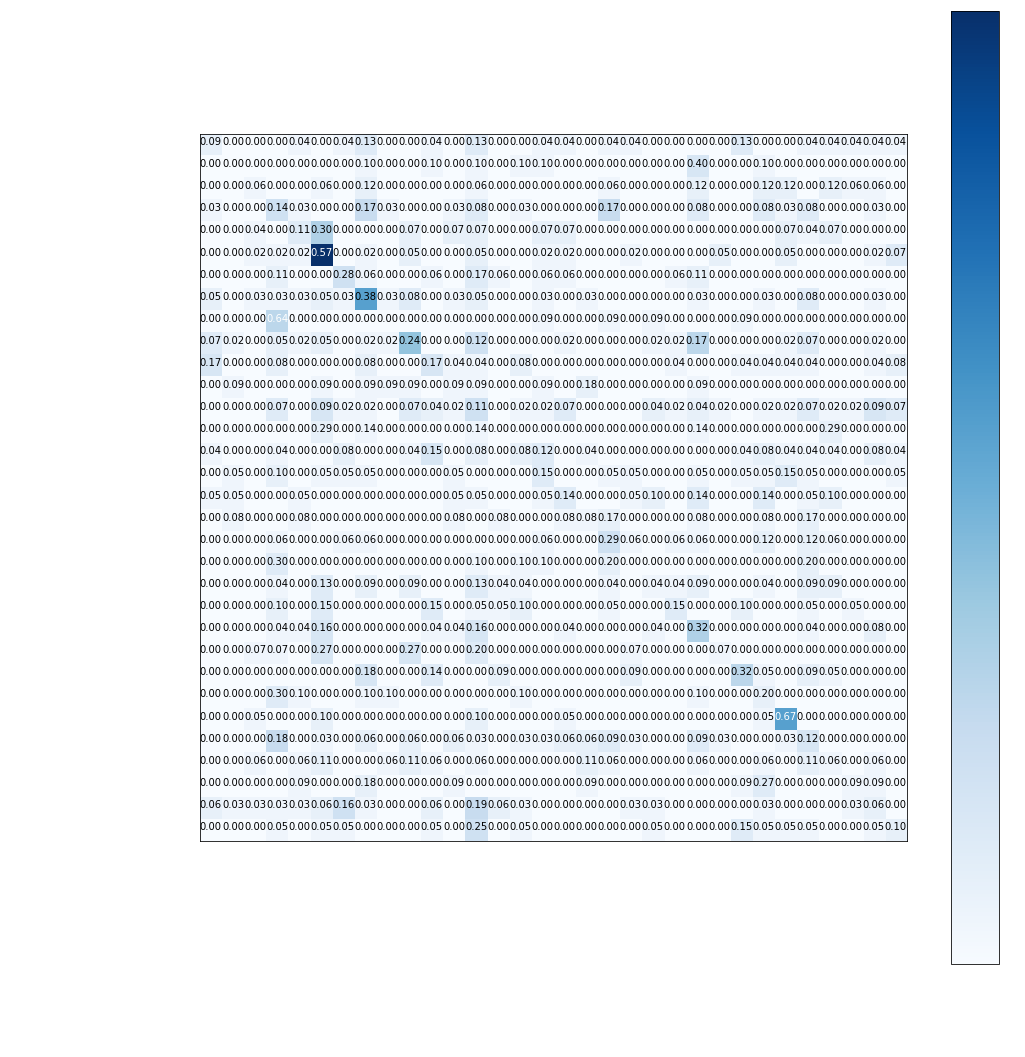

In [1649]:
plot_confusion_matrix(pca_cm, mush_labels, title='Edible Confusion Matrix')

### Trying predict_proba()

In [1650]:
def find_highest_probs(row, top_num=3):
    proba_list = row.nlargest(top_num)
    return ",".join(list(proba_list.index))

def get_probas_from_test(target, test_df, model, top_num=3):
    '''
    Returns df with top n species probabilities appended to each row (for each observation)
    '''
    probas = model.predict_proba(target)
    probas_df = pd.DataFrame(probas, index=test_df.index)
    probas_df.columns = mush_labels

    probas_df['proba_list'] = probas_df.T.apply(lambda row: find_highest_probs(row, top_num))

    return probas_df
    
probas_df = get_probas_from_test(X_test_ss_pca, X_test, log_reg)
probas_df.head()

Agaricus augustus  Agaricus subrutilescens  Amanita augusta  \
468   0.001842           0.000927                 0.000371          
1752  0.004241           0.007145                 0.010333          
248   0.002633           0.003819                 0.006553          
2374  0.001510           0.001320                 0.001798          
786   0.001483           0.009724                 0.005705          

      Amanita calyptroderma  Amanita novinupta  Amanita velosa  \
468   0.000298               0.013428           0.646463         
1752  0.003325               0.000115           0.000291         
248   0.055414               0.002101           0.067393         
2374  0.001216               0.005136           0.004247         
786   0.008670               0.003739           0.063959         

      Armillaria mellea  Boletus edulis  Boletus regineus  \
468   0.001059           0.001243        0.001633           
1752  0.001905           0.004330        0.000830           
248   0.009226           0.005106        0.016410           
2374  0.072037           0.000322        0.000965           
786   0.004981           0.003685        0.068466           

      Cantharellus californicus  Chlorophyllum brunneum  Clavaria fragilis  \
468   0.017257                   0.004281                0.005237            
1752  0.006258                   0.160947                0.014768            
248   0.000514                   0.001578                0.003526            
2374  0.009075                   0.053158                0.000456            
786   0.066344                   0.005761                0.009727            

      Clitocybe nuda  Coprinellus micaceus  Coprinus comatus  \
468   0.000919        0.000402              0.011953           
1752  0.431041        0.000713              0.005463           
248   0.154671        0.014551              0.001411           
2374  0.317758        0.055319              0.002607           
786   0.106513        0.000724              0.057047           

      Entoloma medianox  Gliophorus psittacinus  Gomphidius oregonensis  \
468   0.002827           0.003964                0.002568                 
1752  0.002936           0.008896                0.004344                 
248   0.002912           0.075958                0.001176                 
2374  0.000900           0.006582                0.003223                 
786   0.014396           0.009147                0.003187                 

      Gymnopus dryophilus  Hericium erinaceus  \
468   0.000277             0.000989             
1752  0.000281             0.001027             
248   0.001381             0.023119             
2374  0.000545             0.000512             
786   0.002052             0.001114             

      Laccaria amethysteo-occidentalis  Lacrymaria lacrymabunda  \
468   0.001180                          0.001656                  
1752  0.018697                          0.001724                  
248   0.087128                          0.006918                  
2374  0.002780                          0.038027                  
786   0.106254                          0.000421                  

      Lactarius rubidus  Lactarius rufulus  Laetiporus gilbertsonii  \
468   0.241366           0.001841           0.000158                  
1752  0.015651           0.002674           0.000770                  
248   0.201960           0.001917           0.000690                  
2374  0.009476           0.010281           0.000470                  
786   0.207324           0.058804           0.002141                  

      Leccinum manzanitae  Panaeolus papilionaceus  Pleurotus ostreatus  \
468   0.001738             0.003808                 0.012457              
1752  0.003961             0.000435                 0.002564              
248   0.070687             0.000091                 0.074223              
2374  0.003600             0.162872                 0.010939              
786   0.003777        

In [1614]:
### code moved to function get_probas_from_test
# probas = log_reg.predict_proba(X_test_ss_pca)
# probas_df = pd.DataFrame(probas, index=X_test.index)
# probas_df.columns = mush_labels
# probas_df

In [1633]:
# def find_highest_probs(row, top_num=3):
#     # print(row.nlargest(3))
#     proba_list = row.nlargest(top_num)
#     # print(three_prob.index)
#     # print(list(three_prob))
#     # print(",".join(list(three_prob.index)))
#     return ",".join(list(proba_list.index))
    
# probas_df['proba_list'] = probas_df.T.apply(lambda row: find_highest_probs(row, 3))
# probas_df.head()

In [1586]:
# X_test[['year', 'is_redwood']]
# y_test_lr = decode_labels(label_enc, y_test)

In [1665]:
def analyze_preds(actuals, probas, test_df, le):
    actual_vals = decode_labels(le, actuals)
    preds_df = pd.DataFrame(data=None, index=X_test.index)
    preds_df['actual'] = pd.Series(decode_labels(le, actuals), index=X_test.index)
    preds_df['proba_list'] = pd.Series(probas['proba_list'], index=X_test.index)

#     correct_preds = []
#     for index, row in preds_df.iterrows():
#         if row['predictions'] in row['three_prob']:
#             my_list.append(row)
    
    return preds_df

preds_df = analyze_preds(y_test, probas_df, X_test, label_enc)
# len(preds_df)
preds_df.head()

actual  \
468   Amanita velosa               
1752  Lactarius rufulus            
248   Amanita calyptroderma        
2374  Volvopluteus gloiocephalus   
786   Cantharellus californicus    

                                                             proba_list  
468   Amanita velosa,Lactarius rubidus,Cantharellus californicus         
1752  Clitocybe nuda,Suillus pungens,Chlorophyllum brunneum              
248   Lactarius rubidus,Clitocybe nuda,Pluteus cervinus                  
2374  Clitocybe nuda,Volvopluteus gloiocephalus,Panaeolus papilionaceus  
786   Lactarius rubidus,Clitocybe nuda,Laccaria amethysteo-occidentalis

In [1654]:
# # X_c = edible_by_species_clustered_weather.copy()
# X_c = X_test[['year', 'is_redwood']]
# # X_c = X_test_ss[X_test_ss['id']]
# # X_c = pd.concat(X_c, pd.Series(y_test_lr, name='Predictions'))
# # X_c = pd.concat([X_c, pd.Series(y_test_lr, name='Predictions')], axis=1)
# X_c['predictions'] = pd.Series(y_test_lr, index=X_c.index)
# X_c['three_prob'] = pd.Series(probas_df['three_prob'], index=X_c.index)
# X_c.head(10)

# # X_test_ss['three_prob'] = probas_df['three_prob']
# # X_test_ss_c.head()

In [1667]:
# def filter_preds_df(row):
#     if row['actual'] in row['proba_list']:
#         return row

# preds_df.apply(filter_preds_df, axis=1)

# [x for x in preds_df if x['actual'].isin(x['proba_list'])]
# preds_df[preds_df['actual'] in preds_df['proba_list']]
preds_df[preds_df['actual'].isin(['Amanita', 'californi'])]

Empty DataFrame
Columns: [actual, proba_list]
Index: []

In [1655]:
my_list = []
for index, row in X_c.iterrows():
    if row['predictions'] in row['three_prob']:
        my_list.append(row)

pd.DataFrame(my_list)

year  is_redwood                       predictions  \
1119  2007  0           Coprinus comatus                   
2003  2014  0           Panaeolus papilionaceus            
50    2011  0           Agaricus augustus                  
1220  2015  0           Entoloma medianox                  
1963  2018  0           Panaeolus papilionaceus            
461   2011  0           Amanita velosa                     
244   2014  1           Amanita calyptroderma              
873   2014  0           Chlorophyllum brunneum             
1300  2014  0           Gliophorus psittacinus             
1813  2015  0           Laetiporus gilbertsonii            
643   2014  0           Boletus edulis                     
541   2015  0           Armillaria mellea                  
2104  2006  0           Pleurotus ostreatus                
1550  2007  0           Laccaria amethysteo-occidentalis   
1731  2011  1           Lactarius rubidus                  
651   2014  0           Boletus edulis                     
1498  2013  0           Laccaria amethysteo-occidentalis   
2108  2015  0           Pleurotus ostreatus                
2269  2010  0           Suillus pungens                    
1985  2015  0           Panaeolus papilionaceus            
327   2010  0           Amanita novinupta                  
900   2016  0           Chlorophyllum brunneum             
1886  2010  0           Leccinum manzanitae                
1903  2011  0           Clitocybe nuda                     
729   2017  1           Cantharellus californicus          
973   2016  0           Clitocybe nuda                     
1851  2015  0           Leccinum manzanitae                
593   2010  0           Boletus edulis                     
1939  2011  0           Panaeolus papilionaceus            
690   2007  0           Boletus regineus                   
...    ... ..                        ...                   
1538  2007  0           Laccaria amethysteo-occidentalis   
364   2011  0           Amanita novinupta                  
556   2015  0           Armillaria mellea                  
1270  2014  1           Gliophorus psittacinus             
1595  2008  0           Lacrymaria lacrymabunda            
584   2007  0           Boletus edulis                     
764   2010  0           Cantharellus californicus          
535   2018  0           Amanita velosa                     
2225  2009  0           Suillus fuscotomentosus            
783   2017  0           Cantharellus californicus          
267   2015  0           Amanita calyptroderma              
1214  2010  0           Entoloma medianox                  
433   2017  0           Amanita velosa                     
2188  2009  0           Pluteus cervinus                   
652   2011  0           Boletus edulis                     
1210  2017  1           Entoloma medianox                  
1025  2017  0           Clitocybe nuda                     
1676  2010  0           Lactarius rubidus                  
398   2010  0           Amanita velosa                     
1666  2015  1           Lactarius rubidus                  
1203  2014  0           Entoloma medianox                  
465   2016  1           Amanita velosa                     
2237  2013  0           Suillus fuscotomentosus            
164   2012  0           Amanita augusta                    
1433  2009  0           Gymnopus dryophilus                
481   2013  0           Amanita velosa                     
1542  2011  0           Laccaria amethysteo-occidentalis   
966   2015  0           Clitocybe nuda                     
2027  2015  0           Pleurotus ostreatus                
1802  2007  0           Laetiporus gilbertsonii            

                                                                three_prob  
1119  Panaeolus papilionaceus,Coprinus comatus,Coprinellus micaceus         
2003  Panaeolus papilionaceus,Entoloma medianox,Pleurotus ostreatus         
50    Agaricus augustus,Laetiporus gilbertsonii,Boletu

### Running RandomForestClassifier and PCA

In [569]:
# X = edible_by_species_clustered_weather.copy()
# text_name_dist = X['text_name'].value_counts()
# text_name_dist_df = pd.DataFrame(text_name_dist)
# text_name_dist_df, len(text_name_dist_df)

(                           text_name
 Clitocybe nuda                   148
 Cantharellus californicus        115
 Lactarius rubidus                107
 Boletus edulis                   104
 Amanita novinupta                 85
 Chlorophyllum brunneum            78
 Entoloma medianox                 73
 Coprinus comatus                  72
 Leccinum manzanitae               51
 Lactarius rufulus                 42
 Coprinellus micaceus              39
 Boletus regineus                  38
 Agaricus subrutilescens           38
 Hericium erinaceus                35
 Lactarius deliciosus              20
 Flammulina velutipes              17
 Lentinula edodes                   2, 17)

In [570]:
label_enc = LabelEncoder()

In [571]:
pca = PCA()

X = edible_by_species_clustered_weather.copy()
y = label_enc.fit_transform(X['text_name'])

X = make_weather_data_numeric(X)
X = alter_time_data(X)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

rfc = RandomForestClassifier(max_depth=50, max_features='sqrt')
# rfc.fit_transform(X_train, y_train)
# rfc.score(X_train, y_train)
# rf_preds = rfc.predict(X_test)
# rf_preds

X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)
rfc.fit_transform(X_train_ss_pca, y_train)
cross_val_score(rfc, X_train_ss_pca, y_train), cross_val_score(rfc, X_train_ss_pca, y_train)

/Users/chris/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function transform is deprecated; Support to use estimators as feature selectors will be removed in version 0.19. Use SelectFromModel instead.
  warnings.warn(msg, category=DeprecationWarning)


(array([ 0.2007874 ,  0.19758065,  0.2231405 ]),
 array([ 0.19291339,  0.20564516,  0.19008264]))

In [572]:
X_test.shape, y_test.shape
# y_train.isnull().sum(), y_test.isnull().sum()

((320, 295), (320,))

In [643]:
y_test

array([ 6, 13, 10, 10,  5,  6,  6,  1,  5,  4,  8,  3, 13,  6,  6,  6,  3,
        5,  5, 11,  4,  6, 14, 11, 15,  9,  4, 12,  9,  8, 13, 13, 13, 11,
       13,  8,  1,  6,  6,  2,  9, 13, 15, 13, 15,  4, 14,  6,  6,  4,  9,
        4,  4,  6,  1,  5,  1,  2,  8,  5,  2,  6,  1,  5,  1,  4,  1,  2,
        6,  6, 15, 14, 13,  5,  7, 12,  7,  1,  0,  6,  6,  2,  9,  6, 12,
        4,  6, 14,  9,  4,  6, 12,  2,  7,  3, 11, 15, 12,  3,  4,  1,  5,
        4,  9,  1,  7,  2, 14,  6,  1,  8,  5, 13,  1, 15,  4,  9, 13, 13,
        6,  5, 15,  3, 13, 14,  4,  2,  0, 13,  7,  6,  8,  1,  6,  6,  6,
       15,  6,  8,  4,  2, 15,  8,  6, 13, 15,  0,  1,  4,  5,  4, 10,  6,
        5,  8,  1,  0,  2,  5,  6,  2, 13,  2, 14,  3,  2,  4,  4,  4, 10,
        4,  9,  4,  8,  1,  4,  4,  6,  4,  1,  6,  6, 15,  6, 14, 15,  4,
        4,  6,  2,  4,  8,  3,  3,  5, 13,  1,  1,  6, 12,  7,  4,  6,  2,
       11,  5, 13,  5, 11,  6, 11, 13, 13,  8,  9,  2,  4,  5,  2,  6,  1,
        4,  4,  6,  9, 12

### Decode target labels

In [746]:
X_test_ss = ss.transform(X_test)
pca.transform(X_test_ss)

y_preds_rf = rfc.predict(X_test_ss)
# y_preds_rf = label_enc.inverse_transform(y_preds_rf)
y_preds_rf = decode_labels(label_enc, y_preds_rf)
y_preds_rf

ValueError: Number of features of the model must match the input. Model n_features is 295 and input n_features is 395 

In [993]:
# rf_results = pd.DataFrame([y_test, y_preds])
# rf_results_T = rf_results.T
#
# rf_results_T.isnull().sum()
# rf_results

# y_preds_rf[0:100]
# print(label_enc.inverse_transform(y_preds))

# rf_results = pd.DataFrame([y_preds_rf])
# rf_results.T[0].value_counts(), asd

In [999]:
pca_cm = confusion_matrix(decode_labels(label_enc, y_test), y_preds_rf, labels)

fig, axis = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(pca_cm, square=True, cmap='inferno')

ValueError: Found input variables with inconsistent numbers of samples: [722, 320]

In [677]:
# total = pca_cm.sum(axis=None)
# correct = pca_cm.diagonal().sum()
# print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

In [1019]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(15, 15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [1024]:
# plot_confusion_matrix(pca_cm, labels, title='Edible Confusion Matrix')

In [481]:
X_test['actual'] = y_test
X_test['preds'] = y_preds_rf
X_test[['year', 'actual', 'preds']]

i, j = 0, 0
for index, row in X_test.iterrows():
    if row['actual'] == row['preds']:
        # print(row['actual'], "/", row['preds'])
        j += 1
    i += 1
    
# print(j, '/', i)
X_test['preds'].value_counts(), asd

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


(Boletus edulis             225
 Clitocybe nuda              80
 Amanita novinupta            7
 Entoloma medianox            6
 Agaricus subrutilescens      1
 Chlorophyllum brunneum       1
 Name: preds, dtype: int64,                                   text_name
 Clitocybe nuda                          148
 Amanita velosa                          140
 Pleurotus ostreatus                     120
 Cantharellus californicus               115
 Amanita calyptroderma                   113
 Lactarius rubidus                       107
 Boletus edulis                          104
 Amanita novinupta                        85
 Panaeolus papilionaceus                  84
 Suillus pungens                          83
 Pluteus cervinus                         82
 Chlorophyllum brunneum                   78
 Gliophorus psittacinus                   78
 Agaricus augustus                        75
 Laccaria amethysteo-occidentalis         74
 Entoloma medianox                        73
 Coprinus comatu

### Running SVC with SS/PCA

### Removing Outliers

In [1385]:
ebscw = edible_by_species_clustered_weather.copy()
ebscw = ebscw[ebscw['text_name'] != 'Hydnum repandum']
ebscw = ebscw[ebscw['text_name'] != 'Lentinula edodes']
ebscw = ebscw[ebscw['text_name'] != 'Amanita vaginata']
ebscw = ebscw[ebscw['text_name'] != 'Flammulina velutipes']
ebscw = ebscw[ebscw['text_name'] != 'Lactarius deliciosus']
# ebscw['text_name'].value_counts()
# edible_by_species_clustered_weather['text_name'].value_counts()

In [1476]:
# targets = decode_labels(label_enc, y)
edible_by_species_clustered_weather.head()

id          created_at          text_name   latitude   longitude  \
0  67218  2011-05-11 22:10:54  Agaricus augustus  36.982649 -121.872498   
1  24690  2009-08-24 08:54:47  Agaricus augustus  37.769001 -122.483501   
2  191814 2014-12-05 18:08:54  Agaricus augustus  37.003799 -122.055500   
3  74559  2011-08-24 06:26:43  Agaricus augustus  36.891850 -121.711002   
4  56761  2010-10-26 23:57:43  Agaricus augustus  37.780701 -122.514000   

   is_redwood  is_fir  is_canyon  is_oak grid_code        cluster TMax TMin  \
0  0           0       0          0       147_280   Watsonville    64   52    
1  0           0       0          1       367_157   San Francisco  71   56    
2  0           0       0          0       153_243   Santa Cruz     64   59    
3  0           0       0          0       121_312   Watsonville    84   62    
4  0           0       0          0       370_151   San Francisco  69   42    

  Precip  
0  0.00   
1  0.00   
2  0.19   
3  0.00   
4  0.00

In [1515]:
# xy = pd.concat([X, pd.get_dummies(edible_by_species_clustered_weather)], axis=1).corr()

In [1516]:
# targets = []
# for x in xy.columns:
#     if x[0:10]=='text_name_':
#         targets.append(x)
# targets

In [1517]:
# plt.figure(figsize=(20,20))
# sns.heatmap(abs(xy[targets]),annot=True)

In [1386]:
pca = PCA()

# X = edible_by_species_clustered_weather.copy()
X = ebscw.copy()
y = label_enc.fit_transform(X['text_name'])
X = make_weather_data_numeric(X)
X = alter_time_data(X)
X = X.drop(['id', 'latitude', 'longitude', 'text_name', 'cluster'], axis=1)
X = pd.get_dummies(X, columns=['grid_code', 'month'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=314)

### Bootstrapping

In [1461]:
ebscw_train = X_train.copy()

# ebscw_train['temp_targ'] = pd.Series(y_train, index=ebscw_train.index)
ebscw_train['temp_targ'] = pd.Series(decode_labels(label_enc, y_train), index=ebscw_train.index)
ebscw_train.head()

# ebscw_train['temp_targ'].value_counts()

# unique, counts = np.unique(ebscw_train['], return_counts=True)
# dict(zip(decode_labels(label_enc, unique), counts))

# ebscw_train['temp_targ'].value_counts()

train_count_keys = ebscw_train['temp_targ'].value_counts().index
train_count_values = ebscw_train['temp_targ'].value_counts().values
train_count_dict = dict(zip(train_count_keys, train_count_values))

In [1462]:
# triple_strap_list = ['Leccinum manzanitae', 'Gomphidius oregonensis', 'Clavaria fragilis', 'Lacrymaria lacrymabunda', 'Armillaria mellea', 'Lactarius rufulus', 'Coprinellus micaceus', 'Agaricus subrutilescens', 'Suillus fuscotomentosus', 'Boletus regineus', 'Hericium erinaceus']
# double_strap_list = ['Suillus pungens', 'Pluteus cervinus', 'Gliophorus psittacinus', 'Chlorophyllum brunneum', 'Agaricus augustus', 'Laccaria amethysteo-occidentalis', 'Entoloma medianox', 'Coprinus comatus', 'Amanita augusta', 'Laetiporus gilbertsonii', 'Volvopluteus gloiocephalus', 'Gymnopus dryophilus', 'Amanita novinupta', 'Panaeolus papilionaceus']
# strap_list = ['Coprinus comatus', 'Gymnopus dryophilus', 'Volvopluteus gloiocephalus', 'Laetiporus gilbertsonii', 'Leccinum manzanitae', 'Gomphidius oregonensis', 'Clavaria fragilis', 'Lacrymaria lacrymabunda', 'Armillaria mellea', 'Lactarius rufulus', 'Coprinellus micaceus', 'Agaricus subrutilescens', 'Suillus fuscotomentosus', 'Boletus regineus', 'Hericium erinaceus']

def bootstrap_mush_df_by_species(mush_df, train_dict):
    max_rows = max(train_dict.values())
    for k, v in train_dict.items():
        bs_rows = mush_df[mush_df['temp_targ'] == k].sample(n=(max_rows-v), replace=True)
        mush_df = pd.concat([mush_df, bs_rows])
    return mush_df

### strap
ebscw_train = bootstrap_mush_df_by_species(ebscw_train, train_count_dict)
# for species_name in strap_list:
#     ebscw_train = bootstrap_mush_df_by_species(ebscw_train, species_name, 103, train_count_dict[species_name])

# X['edible'].value_counts()
ebscw_train['temp_targ'].value_counts()

ValueError: A negative number of rows requested. Please provide positive value.

In [1451]:
y_train = label_enc.transform(ebscw_train['temp_targ'])
X_train = ebscw_train.drop(['temp_targ'], axis=1)

In [1452]:
X_train_ss = ss.fit_transform(X_train)
pca.fit(X_train_ss)
X_train_ss_pca = pca.transform(X_train_ss)

svc = SVC(C=35.0, kernel='rbf', gamma='auto', probability=True)
svc.fit(X_train_ss_pca, y_train)

SVC(C=35.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [1453]:
X_train.shape, X_train_ss_pca.shape, X_test.shape

((3296, 388), (3296, 388), (705, 388))

In [1454]:
X_test_ss = ss.transform(X_test)
X_test_ss_pca = pca.transform(X_test_ss)

y_preds_svc = svc.predict(X_test_ss_pca)
y_preds_svc[0:10]

array([ 5, 12, 22, 13,  8,  6, 25, 28,  5, 25])

In [1455]:
cross_val_score(svc, X_train_ss_pca, y_train), cross_val_score(svc, X_test_ss_pca, y_test)

(array([ 0.44107143,  0.49356618,  0.57720588]),
 array([ 0.13469388,  0.11016949,  0.15178571]))

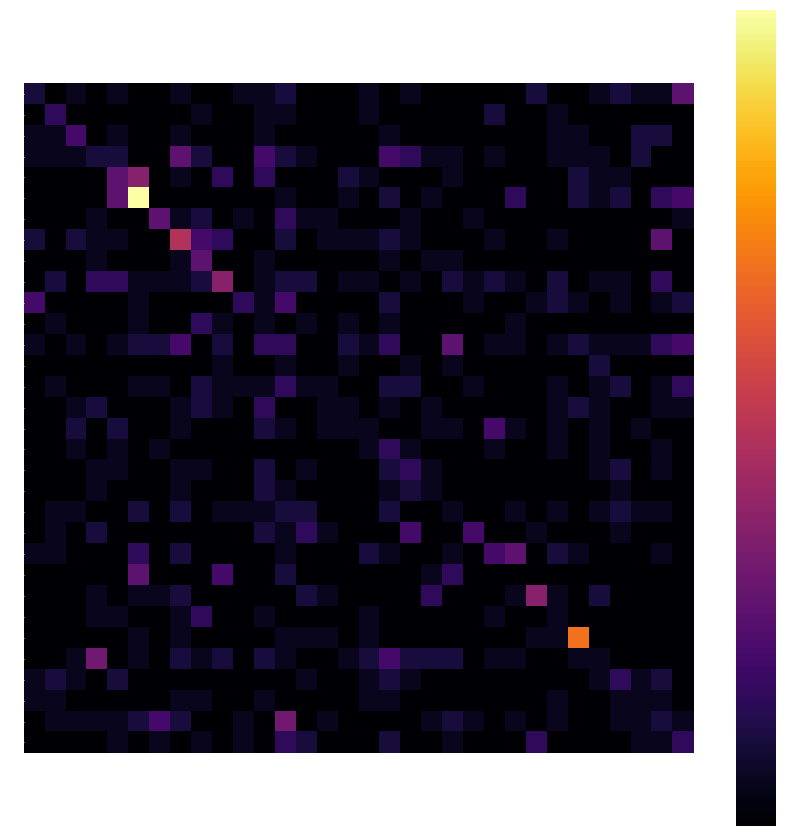

In [1456]:
pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))

fig, axis = plt.subplots(1, 1, figsize=(15, 15), squeeze=False)
sns.heatmap(pca_cm, square=True, cmap='inferno')
# axis[0, 0].title('Confusion Matrix:\n2-Component PCA + SVC')
# ylabel('True')
# xlabel('Predicted')
# show()

In [1457]:
total = pca_cm.sum(axis=None)
correct = pca_cm.diagonal().sum()
print("PCA Accuracy: %0.2f %%" % (100.0 * correct/total))

PCA Accuracy: 16.74 %


In [1404]:
# pca_cm = confusion_matrix(label_enc.inverse_transform(y_test), label_enc.inverse_transform(y_preds_svc))
# pca_cm = confusion_matrix(decode_labels(label_enc, y_test), decode_labels(label_enc, y_preds_svc))
# plot_confusion_matrix(pca_cm, labels, title='Edible Confusion Matrix')

In [1458]:
mush_labels = get_labels(label_enc)
probas = svc.predict_proba(X_test_ss_pca)
probas_df = pd.DataFrame(probas, index=X_test.index)
probas_df.columns = mush_labels
probas_df.head()

Agaricus augustus  Agaricus subrutilescens  Amanita augusta  \
468   0.033315           0.005095                 0.018887          
1752  0.030300           0.006821                 0.020074          
248   0.004394           0.006486                 0.014673          
2374  0.015380           0.005182                 0.018385          
786   0.006495           0.006843                 0.009742          

      Amanita calyptroderma  Amanita novinupta  Amanita velosa  \
468   0.025962               0.031743           0.278797         
1752  0.028570               0.023443           0.046720         
248   0.069658               0.005081           0.016057         
2374  0.009121               0.015964           0.020383         
786   0.013418               0.008060           0.031887         

      Armillaria mellea  Boletus edulis  Boletus regineus  \
468   0.002754           0.032075        0.005215           
1752  0.003779           0.030113        0.005628           
248   0.006435           0.005590        0.006126           
2374  0.024656           0.008062        0.003573           
786   0.006818           0.009378        0.432800           

      Cantharellus californicus  Chlorophyllum brunneum  Clavaria fragilis  \
468   0.042836                   0.030893                0.010137            
1752  0.034358                   0.051282                0.012208            
248   0.016161                   0.004728                0.005005            
2374  0.021179                   0.067779                0.006054            
786   0.031503                   0.006692                0.012283            

      Clitocybe nuda  Coprinellus micaceus  Coprinus comatus  \
468   0.076727        0.011791              0.028538           
1752  0.222695        0.011647              0.022401           
248   0.092359        0.007530              0.002961           
2374  0.089891        0.364992              0.006693           
786   0.045441        0.006582              0.022292           

      Entoloma medianox  Gliophorus psittacinus  Gomphidius oregonensis  \
468   0.010734           0.017699                0.005594                 
1752  0.014278           0.016905                0.006876                 
248   0.017298           0.060728                0.003845                 
2374  0.018262           0.021636                0.011653                 
786   0.013525           0.009597                0.006239                 

      Gymnopus dryophilus  Hericium erinaceus  \
468   0.009637             0.002647             
1752  0.010326             0.003771             
248   0.004806             0.006314             
2374  0.006514             0.002264             
786   0.003967             0.004485             

      Laccaria amethysteo-occidentalis  Lacrymaria lacrymabunda  \
468   0.024410                          0.006908                  
1752  0.026746                          0.006579                  
248   0.108403                          0.004069                  
2374  0.013823                          0.015087                  
786   0.047967                          0.002879                  

      Lactarius rubidus  Lactarius rufulus  Laetiporus gilbertsonii  \
468   0.101212           0.014230           0.011769                  
1752  0.047323           0.014717           0.012543                  
248   0.233008           0.005651           0.003258                  
2374  0.027061           0.008046           0.005452                  
786   0.099493           0.017054           0.005634                  

      Leccinum manzanitae  Panaeolus papilionaceus  Pleurotus ostreatus  \
468   0.006964             0.011593                 0.041470              
1752  0.007472             0.010935                 0.040660              
248   0.153665             0.003753                 0.041564              
2374  0.010702             0.042516                 0.029579              
786   0.005989        

In [1406]:
# def find_highest_probs(row, top_num=3):
#     three_prob = row.nlargest(top_num)
#     return ",".join(list(three_prob.index))
    
# probas_df['three_prob'] = probas_df.T.apply(lambda row: find_highest_probs(row, 5))
# probas_df.head()

In [1459]:
def find_highest_probs(row):
    # print(row.index)
    three_prob = row.nlargest(3)
    return ",".join(list(three_prob.index))

probas_df['three_prob'] = probas_df.T.apply(lambda row: find_highest_probs(row))
# probas_df['three_prob'] = probas_df.T.apply(find_highest_probs)



# probas_df.head()

# # X_c = edible_by_species_clustered_weather.copy()
X_c = X_test[['year', 'is_redwood']]
# # X_c = X_test_ss[X_test_ss['id']]
# # X_c = pd.concat(X_c, pd.Series(y_test_lr, name='Predictions'))
# # X_c = pd.concat([X_c, pd.Series(y_test_lr, name='Predictions')], axis=1)
X_c['predictions'] = pd.Series(decode_labels(label_enc, y_test), index=X_c.index)
X_c['three_prob'] = pd.Series(probas_df['three_prob'], index=X_c.index)
X_c.head(10)

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


year  is_redwood                 predictions  \
468   2015  0           Amanita velosa               
1752  2015  0           Lactarius rufulus            
248   2010  0           Amanita calyptroderma        
2374  2008  0           Volvopluteus gloiocephalus   
786   2018  0           Cantharellus californicus    
548   2015  0           Armillaria mellea            
1670  2008  0           Lactarius rubidus            
2171  2011  0           Pluteus cervinus             
534   2009  0           Amanita velosa               
1979  2012  0           Panaeolus papilionaceus      

                                                                  three_prob  
468   Amanita velosa,Lactarius rubidus,Clitocybe nuda                         
1752  Clitocybe nuda,Suillus pungens,Chlorophyllum brunneum                   
248   Lactarius rubidus,Leccinum manzanitae,Laccaria amethysteo-occidentalis  
2374  Coprinellus micaceus,Clitocybe nuda,Chlorophyllum brunneum              
786   Boletus regineus,Lactarius rubidus,Pleurotus ostreatus                  
548   Armillaria mellea,Clitocybe nuda,Panaeolus papilionaceus                
1670  Leccinum manzanitae,Lactarius rubidus,Clitocybe nuda                    
2171  Pluteus cervinus,Boletus regineus,Amanita calyptroderma                 
534   Amanita velosa,Amanita novinupta,Cantharellus californicus              
1979  Leccinum manzanitae,Amanita calyptroderma,Gliophorus psittacinus

In [1408]:
my_list = []
for index, row in X_c.iterrows():
    if row['predictions'] in row['three_prob']:
        my_list.append(row)

pd.DataFrame(my_list)

year  is_redwood                 predictions  \
468   2015  0           Amanita velosa               
2374  2008  0           Volvopluteus gloiocephalus   
548   2015  0           Armillaria mellea            
1670  2008  0           Lactarius rubidus            
2171  2011  0           Pluteus cervinus             
534   2009  0           Amanita velosa               
50    2011  0           Agaricus augustus            
350   2015  0           Amanita novinupta            
743   2009  0           Cantharellus californicus    
1400  2006  0           Gymnopus dryophilus          
1663  2013  0           Lactarius rubidus            
370   2008  0           Amanita novinupta            
598   2012  0           Boletus edulis               
2063  2010  0           Pleurotus ostreatus          
995   2011  0           Clitocybe nuda               
144   2010  0           Amanita augusta              
1317  2008  0           Gliophorus psittacinus       
1955  2014  0           Panaeolus papilionaceus      
476   2014  0           Amanita velosa               
477   2009  0           Amanita velosa               
1715  2012  0           Lactarius rubidus            
2237  2013  0           Suillus fuscotomentosus      
1707  2010  1           Lactarius rubidus            
479   2012  1           Amanita velosa               
582   2014  0           Boletus edulis               
327   2010  0           Amanita novinupta            
1819  2009  0           Laetiporus gilbertsonii      
833   2009  0           Cantharellus californicus    
2078  2013  0           Pleurotus ostreatus          
1973  2015  0           Panaeolus papilionaceus      
...    ... ..                               ...      
1727  2010  0           Lactarius rubidus            
1587  2013  0           Lacrymaria lacrymabunda      
164   2012  0           Amanita augusta              
1397  2011  0           Gymnopus dryophilus          
1404  2012  0           Gymnopus dryophilus          
497   2011  0           Amanita velosa               
398   2010  0           Amanita velosa               
651   2014  0           Boletus edulis               
1811  2010  0           Laetiporus gilbertsonii      
2222  2014  1           Suillus fuscotomentosus      
2230  2010  0           Suillus fuscotomentosus      
2372  2018  0           Volvopluteus gloiocephalus   
47    2011  0           Agaricus augustus            
1056  2012  0           Clitocybe nuda               
1814  2010  0           Laetiporus gilbertsonii      
850   2010  0           Chlorophyllum brunneum       
501   2018  0           Amanita velosa               
1005  2012  0           Clitocybe nuda               
724   2013  1           Cantharellus californicus    
818   2015  0           Cantharellus californicus    
627   2010  0           Boletus edulis               
446   2010  0           Amanita velosa               
416   2012  1           Amanita velosa               
764   2010  0           Cantharellus californicus    
526   2018  0           Amanita velosa               
1930  2016  0           Clitocybe nuda               
556   2015  0           Armillaria mellea            
2115  2009  0           Pleurotus ostreatus          
1045  2013  0           Clitocybe nuda               
604   2009  0           Boletus edulis               

                                                                   three_prob  
468   Amanita velosa,Lactarius rubidus,Clitocybe nuda                          
2374  Coprinellus micaceus,Volvopluteus gloiocephalus,Clitocybe nuda           
548   Armillaria mellea,Clitocybe nuda,Panaeolus papilionaceus                 
1670  Leccinum manzanitae,Lactarius rubidus,Clitocybe nuda                     
2171  Boletus regineus,Pluteus cervinus,Lacrymaria lacrymabunda                
534   Amanita velosa,Amanita novinupta,Lactarius rubidus                       
50    Laetiporus gilbertsonii,Agaricus augustus,Boletus edulis                 
350   Clavaria fr

In [1344]:
len(X_c)

1350

### Visualizations

In [ ]:
def mushroom_count_by_year(species_list):
    species_input = '|'.join(species_list)
    # return species_input
    query = "SELECT bay_area_names.text_name, count(bay_area_observations.id) AS name_count, bay_area_observations.created_at, YEAR(bay_area_observations.created_at) AS obsv_year FROM bay_area_names LEFT JOIN bay_area_observations ON bay_area_names.id = bay_area_observations.name_id WHERE bay_area_names.text_name REGEXP ('" + species_input + "') GROUP BY obsv_year, text_name;"
    # return query
    mush_by_species_df = pd.read_sql(query, con=mysql_cn)
    return mush_by_species_df    

choice_by_year = mushroom_count_by_year(choice_mushroom_list)
edible_by_year = mushroom_count_by_year(choice_mushroom_list + edible_mushroom_list + not_choice_mushroom_list)
poisonous_by_year = mushroom_count_by_year(poisonous_mushroom_list)
psychoactive_by_year = mushroom_count_by_year(psychoactive_mushroom_list)
other_by_year = mushroom_count_by_year(other_mushroom_list)

# choice_by_year[choice_by_year['obsv_year'] == 2010].head()
choice_by_year.head()

In [1212]:
def chart_mushroom_counts(mushroom_df, prefix=''):
    df = pd.DataFrame
    plt.figure(figsize=(20, 15))
    # plt.xticks(rotation=90)
    plt.title(prefix + ' Mushroom Counts By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    df = mushroom_df.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack()
    plt.plot(df)
    plt.legend(df.columns)

# chart_mushroom_counts(choice_by_year, 'Choice Edible')

In [172]:
# poisonous_by_year.groupby(['obsv_year', 'text_name']).sum()['name_count'].unstack().columns

In [1211]:
# poisonous_by_year
# chart_mushroom_counts(poisonous_by_year, 'Poisonous')

In [1210]:
# chart_mushroom_counts(psychoactive_by_year, 'Psychoactive')

In [1209]:
# chart_mushroom_counts(other_by_year, 'Other')

In [1208]:
def chart_mushroom_counts(mushroom_df):
    plt.figure(figsize=(15, 9))
    plt.xticks(rotation=90)
    plt.title('Mushroom Count By Year\n', fontsize='18', color='w')
    # plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).sum())
    
    plt.plot(mushroom_df['text_name'].groupby(['obsv_year']).count())

# chart_mushroom_counts(choice_by_year)

In [144]:
df_obsv = mush_obsv_df.copy() ##
df_names = mush_names_df.copy()
df_locs = mush_locs_df.copy()
species_list = ['Tuber oregonense', 'Xeromphalina']
obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']

# obsv_df = pd.DataFrame(columns=obsv_cols)
# obsv_df = obsv_df.set_index('id')
obsv_df = pd.DataFrame(data=None, columns=mush_obsv_df.columns)

# df_names

for species in species_list:
    temp_df = pd.DataFrame(columns=obsv_cols)
    temp_df = temp_df.set_index('id')

    ### look up name in names table
    mush_name = df_names[df_names['text_name'] == species]
    mush_name_ids = list(mush_name.index.values)

    ### pull observations based on name_ids
    temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
    temp_df['species_name'] = species

    # , 'text_name', 'location_name'

    ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW

    ### pull locations based on location_ids from observations
    # location_ids = obsv['location_id'].values
    # return location_ids
    # locations = df_locs[df_locs.index.values == location_ids]
    # return locations

    obsv_df = pd.concat([obsv_df, temp_df])

df_locs = df_locs.reset_index('id')
#obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')
#obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])


/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:35: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



In [145]:
obsv_df['name_id'] = obsv_df['name_id'].astype(int)
obsv_df = obsv_df[['name_id','created_at', 'location_id', 'is_collection_location', 'where']]

In [ ]:
df.apply(lambda row['new']: row[0] + row[1])

In [148]:
df_names[df_names['text_name'].map(lambda x: x in species_list)]

version          created_at          updated_at  user_id  \
id                                                               
5           7 2007-01-10 05:03:37 2018-02-04 16:40:56        1   
1019        3 2007-03-04 07:23:32 2012-01-13 23:58:47        2   

      description_id  rss_log_id  num_views           last_view  rank  \
id                                                                      
5             4954.0     21994.0        856 2018-09-08 17:38:25     9   
1019             NaN     93324.0        542 2018-06-22 13:05:08     4   

             text_name                                 search_name  \
id                                                                   
5         Xeromphalina                 Xeromphalina Kühner & Maire   
1019  Tuber oregonense  Tuber oregonense Trappe, Bonito & P. Rawl.   

                                           display_name  \
id                                                        
5                   **__Xeromphalina__** Kühner & Maire   
1019  **__Tuber oregonense__** Trappe, Bonito & P. R...   

                                        sort_name  \
id                                                  
5                    Xeromphalina  Kühner & Maire   
1019  Tuber oregonense  Trappe, Bonito & P. Rawl.   

                                               citation  deprecated  \
id                                                                    
5     Konrad, P.; Maublanc, A. 1937. Icones Selectae...           0   
1019                      Mycologia 102(5): 1053 (2010)           0   

      synonym_id  correct_spelling_id  \
id                                      
5         6577.0                  NaN   
1019         NaN                  NaN   

                                                  notes  \
id                                                        
5     http://www.indexfungorum.org/names/NamesRecord...   
1019      This species is not listed in Index Fungorum.   

                                         classification  ok_for_export  \
id                                                                       
5     Domain: _Eukarya_\r\nKingdom: _Fungi_\r\nPhylu...              1   
1019                                               None              1   

                         author lifeform  locked  
id                                                
5                Kühner & Maire                0  
1019  Trappe, Bonito & P. Rawl.                0

In [36]:
def get_mushrooms_by_species(df_obsv, df_names, df_locs, species_list, obsv_cols=['id', 'created_at', 'location_id', 'is_collection_location', 'where']):
    # obsv_cols = df_obsv.columns
    obsv_df = pd.DataFrame(columns=obsv_cols)
    obsv_df = obsv_df.set_index('id')

    for species in species_list:
        temp_df = pd.DataFrame(columns=obsv_cols)
        temp_df = temp_df.set_index('id')

        ### look up name in names table
        mush_name = df_names[df_names['text_name'] == species]
        mush_name_ids = list(mush_name.index.values)
        
        ### pull observations based on name_ids
        temp_df = df_obsv[df_obsv['name_id'] == mush_name_ids]
        temp_df['species_name'] = species

        # , 'text_name', 'location_name'
        
        ################ NEED TO RUN .apply() TO ASSIGN LOCATION NAMES/NSEW
        
        ### pull locations based on location_ids from observations
        # location_ids = obsv['location_id'].values
        # return location_ids
        # locations = df_locs[df_locs.index.values == location_ids]
        # return locations

        obsv_df = pd.concat([obsv_df, temp_df])
        # obsv_df = obsv_df.reset_index()

        # obsv_df = pd.merge(obsv_df, df_locs[['name', 'north']], left_on='location_id', left_index=False, right_index=True, how='left')

        # df['alpha_posterior'] = df.apply(lambda row: row['hits'] + 27, axis=1)
        # obsv_df['location_name'] = obsv_df.apply(lambda row: locations.index == row['location_id'])
                
        # obsv_df = pd.concat([obsv_df, obsv])
        # obsv_df['']

    # obsv_df = obsv_df.reset_index('id')
    df_locs = df_locs.reset_index('id')
    obsv_df = obsv_df.merge(df_locs[['id', 'name', 'north', 'south', 'east', 'west']], left_on='location_id', right_on='id')

    
    # obsv_df = obsv_df.join(df_locs[['name', 'north', 'south', 'east', 'west']], on='location_id')
    # obsv_df = obsv_df.join(df_locs, on='location_id')
    # obsv_df = pd.concat([obsv_df, df_locs],axis=1)
    
    return obsv_df

# mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Xeromphalina', 'Tuber oregonense'])
mush = get_mushrooms_by_species(mush_obsv_df, mush_names_df, mush_locs_df, ['Tuber oregonense', 'Xeromphalina'])
mush

/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/chris/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:28: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False



ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

### Close MySQL connection

In [ ]:
mysql_cn.close()